## Capstone 2 Project: Prediction of WAR in MLB players

<div class="alert alert-block alert-info">
In this notebook, I will be exploring and answering some statistical questions that I have for the dataset that I had merged 

1. What player metrics are highly correlated?
2. Is there a statistical difference in OBP (On Base Percentage) for players above/below certain BWARP percentiles?
3. Is there a statistical difference in ISO (Isolated Power) for players above/below certain BWARP percentiles?
4. Is there a statistical difference in age for players above/below certain BWARP percentiles?
5. Is there a statistical difference in DRAA (Defensive Runs Above Average) for players above/below certain BWARP percentiles?

In [60]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest as pz
from statsmodels.stats.weightstats import ztest as ztest
import warnings


# disable warnings
warnings.filterwarnings('ignore') 


csvfile = 'capstone_2_df.csv'

mlb_df = pd.read_csv(csvfile)
mlb_df.drop(['SampleID.1', 'POS.1'], axis=1, inplace=True)

pd.set_option('display.max_columns', 50)
plt.style.use('ggplot')

In [2]:
# saving BWARP percentile values
BWARP_95 = np.percentile(mlb_df.BWARP, 95)
BWARP_75 = np.percentile(mlb_df.BWARP, 75)
BWARP_50 = np.percentile(mlb_df.BWARP, 50)
BWARP_25 = np.percentile(mlb_df.BWARP, 25)
BWARP_5 = np.percentile(mlb_df.BWARP, 5)

# creating separate dataframes for different BWARP ranges
mlb_df_below_95 = mlb_df[mlb_df.BWARP <= BWARP_95]
mlb_df_above_95 = mlb_df[mlb_df.BWARP > BWARP_95]
mlb_df_below_75 = mlb_df[mlb_df.BWARP <= BWARP_75]
mlb_df_above_75 = mlb_df[mlb_df.BWARP > BWARP_75]
mlb_df_below_50 = mlb_df[mlb_df.BWARP <= BWARP_50]
mlb_df_above_50 = mlb_df[mlb_df.BWARP > BWARP_50]
mlb_df_below_25 = mlb_df[mlb_df.BWARP <= BWARP_25]
mlb_df_above_25 = mlb_df[mlb_df.BWARP > BWARP_25]
mlb_df_below_5 = mlb_df[mlb_df.BWARP <= BWARP_5]
mlb_df_above_5 = mlb_df[mlb_df.BWARP > BWARP_5]

print('For this data set, these are the values for different BWARP percentiles:\n')
print('95th BWARP percentile: {}'.format(BWARP_95))
print('75th BWARP percentile: {}'.format(BWARP_75))
print('50th BWARP percentile: {}'.format(BWARP_50))
print('25th BWARP percentile: {}'.format(BWARP_25))
print('5th BWARP percentile: {}'.format(BWARP_5))

For this data set, these are the values for different BWARP percentiles:

95th BWARP percentile: 4.6
75th BWARP percentile: 1.9
50th BWARP percentile: 0.6
25th BWARP percentile: -0.0
5th BWARP percentile: -0.5


In [3]:
# function that calculates p-values to determine if there is a significant difference for specified statistic 
# between players that are above and below BWARP percentiles (5, 25, 50, 75, 95) using proportions_ztest

def pz_pvalue_calc(mlb_stat):
    percentile_list = ['5', '25', '50', '75', '95']
    print('\nFrequentist method (proportions ztest): ')
    
    for percentile in percentile_list:
        below_percentile_df = globals()['mlb_df_below_' + percentile]
        above_percentile_df = globals()['mlb_df_above_' + percentile]
        zstat, pval = pz(np.array([below_percentile_df[mlb_stat].mean(), above_percentile_df[mlb_stat].mean()]), np.array([len(below_percentile_df), len(above_percentile_df)]), value=0)
        print('P-value for {0} difference between players above and below {1}th BWARP percentile: {2}'.format(mlb_stat, percentile, pval.round(4)))

In [4]:
# performs same calculation as above pz_pvalue_calc function, but breaks down by position
def pz_pvalue_by_pos_calc(mlb_stat):
    position_list = ['C', '1B', '2B', '3B', 'SS', 'OF']
    percentile_list = ['5', '25', '50', '75', '95']
    print('\nFrequentist method (proportions ztest): ')
    
    for position in position_list:
        print('\nFor {} position:'.format(position))
        for percentile in percentile_list:
            below_percentile_df = globals()['mlb_df_below_' + percentile]
            below_percentile_df = below_percentile_df[below_percentile_df.POS == position]
            above_percentile_df = globals()['mlb_df_above_' + percentile]
            above_percentile_df = above_percentile_df[above_percentile_df.POS == position]
            zstat, pval = pz(np.array([below_percentile_df[mlb_stat].mean(), above_percentile_df[mlb_stat].mean()]), np.array([len(below_percentile_df), len(above_percentile_df)]), value=0)
            print('P-value for {0} difference between {1} above and below {2}th BWARP percentile: {3}'.format(mlb_stat, position, percentile, pval.round(3)))

In [74]:
# function that calculates p-values to determine if there is a significant difference for specified statistic 
# between players that are above and below BWARP percentiles (5, 25, 50, 75, 95) ztest

def ztest_pvalue_calc(mlb_stat):
    percentile_list = ['5', '25', '50', '75', '95']
    print('\nFrequentist method (ztest): ')
    
    for percentile in percentile_list:
        below_percentile_df = globals()['mlb_df_below_' + percentile]
        above_percentile_df = globals()['mlb_df_above_' + percentile]
        zstat, pval = ztest(np.array([below_percentile_df[mlb_stat].mean(), above_percentile_df[mlb_stat].mean()]))
        print('P-value for {0} difference between players above and below {1}th BWARP percentile: {2}'.format(mlb_stat, percentile, pval.round(4)))

In [75]:
# performs same calculation as above ztest_pvalue_calc function, but breaks down by position
def ztest_pvalue_by_pos_calc(mlb_stat):
    position_list = ['C', '1B', '2B', '3B', 'SS', 'OF']
    percentile_list = ['5', '25', '50', '75', '95']
    print('\nFrequentist method (ztest): ')
    
    for position in position_list:
        print('\nFor {} position:'.format(position))
        for percentile in percentile_list:
            below_percentile_df = globals()['mlb_df_below_' + percentile]
            below_percentile_df = below_percentile_df[below_percentile_df.POS == position]
            above_percentile_df = globals()['mlb_df_above_' + percentile]
            above_percentile_df = above_percentile_df[above_percentile_df.POS == position]
            zstat, pval = ztest(np.array([below_percentile_df[mlb_stat].mean(), above_percentile_df[mlb_stat].mean()]))
            print('P-value for {0} difference between {1} above and below {2}th BWARP percentile: {3}'.format(mlb_stat, position, percentile, pval.round(3)))

In [89]:
# function that calculates p-values to determine if there is a significant difference for specified statistic 
# between players that are above and below BWARP percentiles (5, 25, 50, 75, 95) using ttest_ind

def ttest_pvalue_calc(mlb_stat):
    percentile_list = ['5', '25', '50', '75', '95']
    print('\nFrequentist method (t-test of 2 ind samples): ')
    
    for percentile in percentile_list:
        below_percentile_df = globals()['mlb_df_below_' + percentile]
        above_percentile_df = globals()['mlb_df_above_' + percentile]
        tstat, pval = st.ttest_ind(below_percentile_df[mlb_stat], above_percentile_df[mlb_stat], equal_var = False)
        print('P-value for {0} difference between players above and below {1}th BWARP percentile: {2}'.format(mlb_stat, percentile, pval.round(5)))

In [88]:
# performs same calculation as above ttest_pvalue_calc function, but breaks down by position

def ttest_pvalue_by_pos_calc(mlb_stat):
    position_list = ['C', '1B', '2B', '3B', 'SS', 'OF']
    percentile_list = ['5', '25', '50', '75', '95']
    print('\nFrequentist method (t-test of 2 ind samples): ')
    
    for position in position_list:
        print('\nFor {} position:'.format(position))
        for percentile in percentile_list:
            below_percentile_df = globals()['mlb_df_below_' + percentile]
            below_percentile_df = below_percentile_df[below_percentile_df.POS == position]
            above_percentile_df = globals()['mlb_df_above_' + percentile]
            above_percentile_df = above_percentile_df[above_percentile_df.POS == position]
            tstat, pval = st.ttest_ind(below_percentile_df[mlb_stat], above_percentile_df[mlb_stat], equal_var = False)
            print('P-value for {0} difference between {1} above and below {2}th BWARP percentile: {3}'.format(mlb_stat, position, percentile, pval.round(5)))

In [7]:
mlb_df.head()

,SampleID,POS,NAME,yearID,playerID,lahmanID,teamID,AGE,G,GS,League,PA,AB,R,H,1B,2B,3B,HR,TB,BB,IBB,SO,SF,SH,...,DP,SB,CS,AVG,OBP,SLG,OPS,ISO,oppOPS,DRC+,DRC+ SD,BRR,BWARP,InnOuts,Def_PO,Def_A,Def_E,Def_DP,Def_PB,Def_WP,Def_SB,Def_CS,Def_ZR,Def_DRAA,Def_FRAA
0,3,OF,Barry Bonds,2004,bondsba,bondsba01,SFN,39,147,132.0,NL,617,373,129,135,60,27,3,45,303,232,120,41,3,0,...,5,6,1,0.362,0.609,0.812,1.422,0.450,0.750,243,12,-2.1,12.2,3392.0,214,11,4.0,0,0.0,0.0,0.0,0.0,0.0,118.4,-5.6
1,6,OF,Barry Bonds,2001,bondsba,bondsba01,SFN,36,153,141.0,NL,664,476,129,156,49,32,2,73,411,177,35,93,2,0,...,5,13,3,0.328,0.515,0.863,1.379,0.536,0.757,240,12,-0.1,11.8,3695.0,246,8,6.0,1,0.0,0.0,0.0,0.0,0.0,121.4,-16.6
2,8,1B,Albert Pujols,2009,pujolal,pujolal01,SLN,29,160,157.0,NL,700,568,124,186,93,45,1,47,374,115,44,64,8,0,...,23,16,4,0.327,0.443,0.658,1.101,0.331,0.748,178,12,1.5,11.6,4130.0,1473,185,13.0,150,0.0,0.0,0.0,0.0,0.0,73.0,33.7
3,10,OF,Barry Bonds,2002,bondsba,bondsba01,SFN,37,143,133.0,NL,612,403,117,149,70,31,2,46,322,198,68,47,2,0,...,4,9,2,0.370,0.582,0.799,1.381,0.429,0.751,240,10,-4.9,10.8,3345.0,241,4,8.0,2,0.0,0.0,0.0,0.0,0.0,108.4,-9.4
4,15,OF,Jose Bautista,2011,bautijo,bautijo02,TOR,30,149,25.0,AL,655,513,105,155,86,24,2,43,312,132,24,111,4,0,...,8,9,5,0.302,0.447,0.608,1.056,0.306,0.729,185,11,1.4,10.6,3657.0,250,75,8.0,6,0.0,0.0,0.0,0.0,0.0,68.2,17.4


__1. What player metrics are highly correlated?__

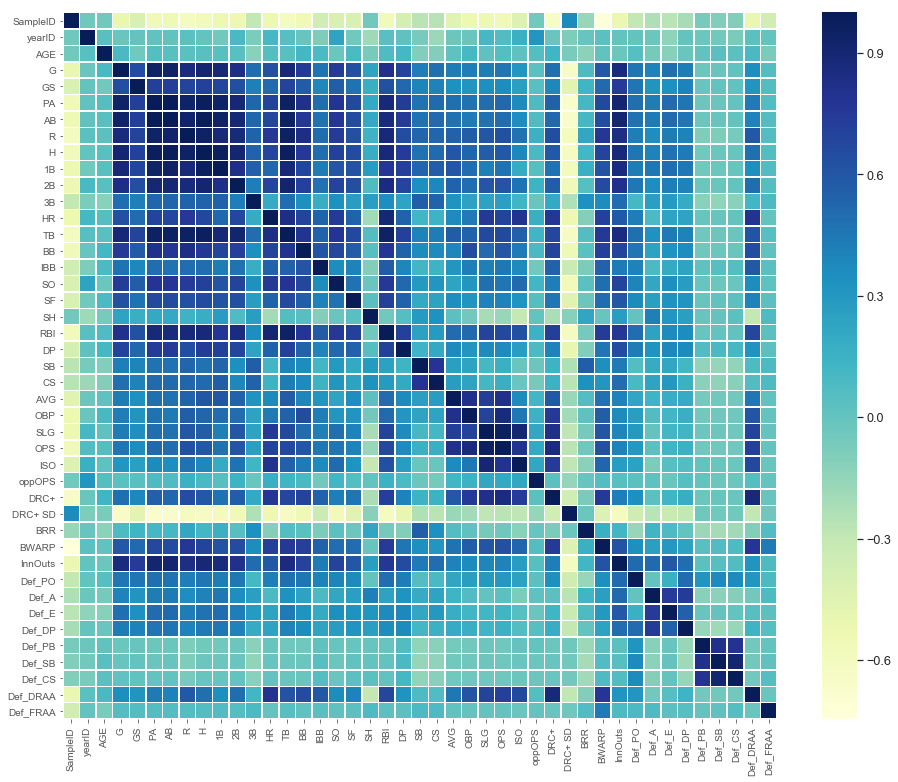

In [9]:
# selecting float and int columns
heat_map_df = mlb_df.select_dtypes(include=['int', 'float'])
heat_map_df.drop(columns=['Def_WP', 'Def_ZR'], inplace=True)
heat_map_df.corr()

fig, ax = plt.subplots(figsize=(16,13)) 
sns.set(style="whitegrid", font_scale=1.15)
sns.heatmap(heat_map_df.corr(), linewidths=.5, cmap="YlGnBu", ax=ax)

__2. Using alpha = 0.05, is there a significant difference in OBP (On Base Percentage) between players that have a BWARP above and below the 5th, 25th, 50th, 75th and 95th percentiles?__

H0: There is no significant difference in OBP between players that have a BWARP above and below the 5th percentile. (Repeat for 25th, 50th, 75th and 95th percentile).

Ha: There is a significant difference in OBP between players that have a BWARP above and below the 5th percentile (Repeat for 25th, 50th, 75th and 95th percentile).

In [78]:
pz_pvalue_calc('OBP')


Frequentist method (proportions ztest): 
P-value for OBP difference between players above and below 5th BWARP percentile: 0.1873
P-value for OBP difference between players above and below 25th BWARP percentile: 0.7304
P-value for OBP difference between players above and below 50th BWARP percentile: 0.9368
P-value for OBP difference between players above and below 75th BWARP percentile: 0.5729
P-value for OBP difference between players above and below 95th BWARP percentile: 0.0526


In [79]:
pz_pvalue_by_pos_calc('OBP')


Frequentist method (proportions ztest): 

For C position:
P-value for OBP difference between C above and below 5th BWARP percentile: 0.132
P-value for OBP difference between C above and below 25th BWARP percentile: 0.652
P-value for OBP difference between C above and below 50th BWARP percentile: 0.926
P-value for OBP difference between C above and below 75th BWARP percentile: 0.512
P-value for OBP difference between C above and below 95th BWARP percentile: 0.018

For 1B position:
P-value for OBP difference between 1B above and below 5th BWARP percentile: 0.176
P-value for OBP difference between 1B above and below 25th BWARP percentile: 0.801
P-value for OBP difference between 1B above and below 50th BWARP percentile: 0.92
P-value for OBP difference between 1B above and below 75th BWARP percentile: 0.571
P-value for OBP difference between 1B above and below 95th BWARP percentile: 0.073

For 2B position:
P-value for OBP difference between 2B above and below 5th BWARP percentile: 0.255
P

__3. Using alpha = 0.05, is there a significant difference in ISO (Isolated Power) between players that have a BWARP above and below the 5th, 25th, 50th, 75th and 95th percentiles?__

H0: There is no significant difference in ISO between players that have a BWARP above and below the 5th percentile. (Repeat for 25th, 50th, 75th and 95th percentile).

Ha: There is a significant difference in ISO between players that have a BWARP above and below the 5th percentile (Repeat for 25th, 50th, 75th and 95th percentile).

In [83]:
pz_pvalue_calc('ISO')


Frequentist method (proportions ztest): 
P-value for ISO difference between players above and below 5th BWARP percentile: 0.4836
P-value for ISO difference between players above and below 25th BWARP percentile: 0.8792
P-value for ISO difference between players above and below 50th BWARP percentile: 0.9074
P-value for ISO difference between players above and below 75th BWARP percentile: 0.6429
P-value for ISO difference between players above and below 95th BWARP percentile: 0.1054


In [81]:
pz_pvalue_by_pos_calc('ISO')


Frequentist method (proportions ztest): 

For C position:
P-value for ISO difference between C above and below 5th BWARP percentile: 0.407
P-value for ISO difference between C above and below 25th BWARP percentile: 0.819
P-value for ISO difference between C above and below 50th BWARP percentile: 0.912
P-value for ISO difference between C above and below 75th BWARP percentile: 0.615
P-value for ISO difference between C above and below 95th BWARP percentile: 0.07

For 1B position:
P-value for ISO difference between 1B above and below 5th BWARP percentile: 0.423
P-value for ISO difference between 1B above and below 25th BWARP percentile: 0.923
P-value for ISO difference between 1B above and below 50th BWARP percentile: 0.889
P-value for ISO difference between 1B above and below 75th BWARP percentile: 0.621
P-value for ISO difference between 1B above and below 95th BWARP percentile: 0.123

For 2B position:
P-value for ISO difference between 2B above and below 5th BWARP percentile: 0.594
P

__4. Using alpha = 0.05, is there a significant difference in age between players that have a BWARP above and below the 5th, 25th, 50th, 75th and 95th percentiles?__

H0: There is no significant difference in the age between players that have a BWARP above and below the 5th percentile. (Repeat for 25th, 50th, 75th and 95th percentile).

Ha: There is a significant difference in the age between players that have a BWARP above and below the 5th percentile (Repeat for 25th, 50th, 75th and 95th percentile).

In [90]:
ttest_pvalue_calc('AGE')


Frequentist method (t-test of 2 ind samples): 
P-value for AGE difference between players above and below 5th BWARP percentile: 0.01378
P-value for AGE difference between players above and below 25th BWARP percentile: 0.0
P-value for AGE difference between players above and below 50th BWARP percentile: 0.0
P-value for AGE difference between players above and below 75th BWARP percentile: 0.40695
P-value for AGE difference between players above and below 95th BWARP percentile: 0.00096


In [91]:
ttest_pvalue_by_pos_calc('AGE')


Frequentist method (t-test of 2 ind samples): 

For C position:
P-value for AGE difference between C above and below 5th BWARP percentile: 0.90354
P-value for AGE difference between C above and below 25th BWARP percentile: 0.0949
P-value for AGE difference between C above and below 50th BWARP percentile: 0.07672
P-value for AGE difference between C above and below 75th BWARP percentile: 0.80606
P-value for AGE difference between C above and below 95th BWARP percentile: 2e-05

For 1B position:
P-value for AGE difference between 1B above and below 5th BWARP percentile: 0.48564
P-value for AGE difference between 1B above and below 25th BWARP percentile: 0.50635
P-value for AGE difference between 1B above and below 50th BWARP percentile: 0.49803
P-value for AGE difference between 1B above and below 75th BWARP percentile: 0.47877
P-value for AGE difference between 1B above and below 95th BWARP percentile: 0.13758

For 2B position:
P-value for AGE difference between 2B above and below 5th B

__5. Using alpha = 0.05, is there a significant difference in DRAA between players that have a BWARP above and below the 5th, 25th, 50th, 75th and 95th percentiles?__

H0: There is no significant difference in DRAA between players that have a BWARP above and below the 5th percentile. (Repeat for 25th, 50th, 75th and 95th percentile).

Ha: There is a significant difference in DRAA between players that have a BWARP above and below the 5th percentile (Repeat for 25th, 50th, 75th and 95th percentile).

In [76]:
ztest_pvalue_calc('Def_DRAA')


Frequentist method (ztest): 
P-value for Def_DRAA difference between players above and below 5th BWARP percentile: 0.5651
P-value for Def_DRAA difference between players above and below 25th BWARP percentile: 0.9151
P-value for Def_DRAA difference between players above and below 50th BWARP percentile: 0.756
P-value for Def_DRAA difference between players above and below 75th BWARP percentile: 0.4823
P-value for Def_DRAA difference between players above and below 95th BWARP percentile: 0.3169


In [77]:
ztest_pvalue_by_pos_calc('Def_DRAA')


Frequentist method (ztest): 

For C position:
P-value for Def_DRAA difference between C above and below 5th BWARP percentile: 0.234
P-value for Def_DRAA difference between C above and below 25th BWARP percentile: 0.344
P-value for Def_DRAA difference between C above and below 50th BWARP percentile: 0.78
P-value for Def_DRAA difference between C above and below 75th BWARP percentile: 0.692
P-value for Def_DRAA difference between C above and below 95th BWARP percentile: 0.399

For 1B position:
P-value for Def_DRAA difference between 1B above and below 5th BWARP percentile: 0.762
P-value for Def_DRAA difference between 1B above and below 25th BWARP percentile: 0.503
P-value for Def_DRAA difference between 1B above and below 50th BWARP percentile: 0.383
P-value for Def_DRAA difference between 1B above and below 75th BWARP percentile: 0.266
P-value for Def_DRAA difference between 1B above and below 95th BWARP percentile: 0.201

For 2B position:
P-value for Def_DRAA difference between 2B ab

__Summary:__

From the results in this notebook, there are some insights and learnings that we 

1. The data shows high correlation coefficients between BWARP and offensive statistics, in particular: TB, DRC+, RBI, R, HR, BB.  Of the defensive statistics, it is most highly correlated with DRAA.
2. For most positions, players in the top 5% of BWARP have a statistically different OBP than players in the bottom 95% of BWARP.
3. For SS, it appears that there is a larger difference in DRAA between players below the 50th BWARP percentile and those above the 50th BWARP percentile.
4. For most positions, players in the top 5% of BWARP have a statistically different age than players in the bottom 95% of BWARP.